In [1]:
import numpy as np
import pandas as pd
import os
from datetime import datetime

In [2]:
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [3]:
dir="data/"

In [4]:
df=pd.read_csv(dir+"GOOG.csv")  # read the data
df.head()  # print the summary of the data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-09-01,47.056499,47.124001,46.757500,46.867001,46.867001,18948000
1,2017-09-05,46.653999,46.849998,46.098000,46.422501,46.422501,26528000
2,2017-09-06,46.507500,46.545750,45.963501,46.390499,46.390499,30554000
3,2017-09-07,46.586498,46.820499,46.181000,46.797501,46.797501,24254000
4,2017-09-08,46.824501,46.849499,46.243999,46.325001,46.325001,20230000


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,82.767391,83.667386,81.913428,82.806675,82.806675,3.102087e+07
std,32.311184,32.633284,31.948660,32.277134,32.277134,1.359313e+07
min,45.870998,46.104000,45.485001,45.750000,45.750000,6.936000e+06
25%,56.346373,57.056126,55.833039,56.491998,56.491998,2.251200e+07
50%,67.585751,68.242001,67.174499,67.612747,67.612747,2.783600e+07
75%,113.282623,114.807499,112.140499,113.340628,113.340628,3.531300e+07
max,151.863495,152.100006,149.887497,150.709000,150.709000,1.241400e+08


In [6]:
df.isnull().sum().sum()  # check if there is any missing value

0

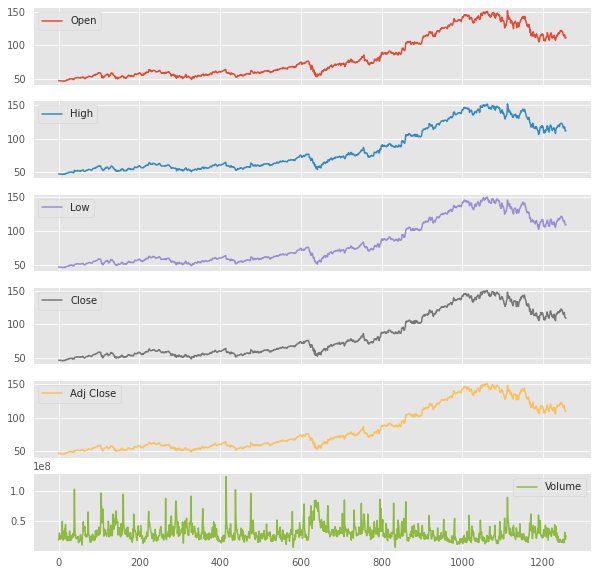

In [7]:
df.plot(legend=True,subplots=True, figsize=(10,10))  # plot the data
plt.show()

In [8]:
df.iloc[1,4]

46.422501

In [9]:
##Close Price

In [10]:
from sklearn.model_selection import train_test_split

X_close=[]
Y_close=[]
window_size=100

for i in range(1,len(df)-window_size):
    first=df.iloc[i,3]
    temp=[]
    temp2=[]
    for j in range(window_size):
        temp.append((df.iloc[i+j,3]-first)/first)
    temp2.append((df.iloc[i+window_size,3]-first)/first)
    X_close.append(np.array(temp).reshape(window_size,1))
    Y_close.append(np.array(temp2).reshape(1,1))

In [11]:
x_close_train, x_close_test, y_close_train, y_close_test = train_test_split(X_close, Y_close, test_size=0.2, random_state=42,shuffle=True)
x_close_train, x_close_test, y_close_train, y_close_test=np.array(x_close_train),np.array(x_close_test),np.array(y_close_train),np.array(y_close_test)
x_close_train=x_close_train.reshape(x_close_train.shape[0],1,window_size,1)
x_close_test=x_close_test.reshape(x_close_test.shape[0],1,window_size,1)

In [12]:
x_close_train.shape

(925, 1, 100, 1)

In [13]:
x_close_train

array([[[[ 0.00000000e+00],
         [ 1.50223409e-03],
         [-2.19463807e-02],
         ...,
         [ 2.67564418e-02],
         [ 2.86390927e-02],
         [ 2.99776390e-02]]],


       [[[ 0.00000000e+00],
         [-1.61465379e-03],
         [ 1.15268925e-02],
         ...,
         [ 1.28166465e-01],
         [ 1.11758297e-01],
         [ 1.14156600e-01]]],


       [[[ 0.00000000e+00],
         [-7.69841425e-03],
         [-9.30063777e-03],
         ...,
         [ 1.11714610e-01],
         [ 1.19481372e-01],
         [ 1.03199521e-01]]],


       ...,


       [[[ 0.00000000e+00],
         [-1.12041673e-05],
         [-2.26631601e-02],
         ...,
         [-1.61298723e-01],
         [-1.93599745e-01],
         [-1.98021426e-01]]],


       [[[ 0.00000000e+00],
         [ 8.19545765e-03],
         [ 1.43983568e-02],
         ...,
         [ 2.43127576e-01],
         [ 2.38075177e-01],
         [ 2.33471228e-01]]],


       [[[ 0.00000000e+00],
         [ 5.61096773e-02],


In [14]:
y_close_train

array([[[ 2.14359805e-02]],

       [[ 1.15593979e-01]],

       [[ 1.05579361e-01]],

       [[ 1.95027634e-01]],

       [[ 2.13746698e-02]],

       [[ 1.56447244e-01]],

       [[ 1.56473109e-01]],

       [[ 6.21856806e-02]],

       [[-1.68501172e-02]],

       [[ 1.30388673e-01]],

       [[ 4.69259704e-02]],

       [[ 1.79368098e-01]],

       [[-3.51547559e-02]],

       [[ 2.02908894e-01]],

       [[ 1.10181869e-02]],

       [[ 1.20793452e-01]],

       [[ 3.44181833e-01]],

       [[ 3.10012788e-01]],

       [[ 3.60575586e-01]],

       [[-1.21671448e-01]],

       [[ 1.16768422e-01]],

       [[ 4.97442500e-02]],

       [[-8.76235470e-02]],

       [[ 1.98651456e-02]],

       [[ 1.33445930e-01]],

       [[-1.15718847e-02]],

       [[-1.51299055e-02]],

       [[ 1.55416711e-01]],

       [[-2.49822169e-01]],

       [[ 1.33054777e-01]],

       [[-2.70671364e-02]],

       [[-3.85539203e-02]],

       [[-5.55193303e-03]],

       [[ 2.11333756e-01]],

       [[-6.63

In [15]:
len(x_close_train)

925

In [16]:
##Train the model

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

2022-09-17 23:18:57.314376: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [18]:
model=tf.keras.Sequential()

model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))

# LSTM layers
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

#Final layers
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

history = model.fit(x_close_train, y_close_train, validation_data=(x_close_test,y_close_test), epochs=40,batch_size=40, verbose=1, shuffle =True)

2022-09-17 23:18:58.106206: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-17 23:18:58.106990: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-17 23:18:58.136292: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 23:18:58.136429: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.6575GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-17 23:18:58.136447: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-17 23:18:58.137589: I tensorflow/stream_executor/platfo

Epoch 1/40


2022-09-17 23:19:01.848314: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-09-17 23:19:01.942631: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-09-17 23:19:02.324377: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-09-17 23:19:02.363198: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


24/24 [==============================] - 12s 227ms/step - loss: 0.0220 - mse: 0.0220 - mae: 0.1197 - val_loss: 0.0077 - val_mse: 0.0077 - val_mae: 0.0709
Epoch 2/40
24/24 [==============================] - 0s 9ms/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0691 - val_loss: 0.0070 - val_mse: 0.0070 - val_mae: 0.0642
Epoch 3/40
24/24 [==============================] - 0s 8ms/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0592 - val_loss: 0.0053 - val_mse: 0.0053 - val_mae: 0.0543
Epoch 4/40
24/24 [==============================] - 0s 9ms/step - loss: 0.0046 - mse: 0.0046 - mae: 0.0539 - val_loss: 0.0053 - val_mse: 0.0053 - val_mae: 0.0519
Epoch 5/40
24/24 [==============================] - 0s 8ms/step - loss: 0.0048 - mse: 0.0048 - mae: 0.0518 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0446
Epoch 6/40
24/24 [==============================] - 0s 7ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0488 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0452
Epoch 7/40
24/24 [==================

In [29]:
predicted=model.predict(x_close_test)

In [30]:
predicted

array([[ 1.72629848e-01],
       [-3.82343568e-02],
       [ 1.80484667e-01],
       [ 1.16943479e-01],
       [ 1.09458193e-01],
       [ 9.63414758e-02],
       [ 3.18155617e-01],
       [-1.86033681e-01],
       [ 1.76748276e-01],
       [-3.69495116e-02],
       [-4.17003036e-03],
       [ 2.03949928e-01],
       [ 2.22324044e-01],
       [ 2.22577751e-01],
       [ 2.70774141e-02],
       [-1.57322049e-01],
       [ 3.59022975e-01],
       [ 1.22822836e-01],
       [ 8.50441307e-02],
       [ 1.25510573e-01],
       [-6.29130602e-02],
       [ 1.50533244e-01],
       [ 2.05768794e-02],
       [-2.00249910e-01],
       [ 8.09963793e-02],
       [-3.66333537e-02],
       [ 8.29073638e-02],
       [ 1.75990462e-01],
       [ 2.54852682e-01],
       [-1.59084350e-01],
       [ 1.64768338e-01],
       [ 1.70209989e-01],
       [-1.09968893e-02],
       [ 5.03329784e-02],
       [ 1.94616824e-01],
       [ 1.69788003e-01],
       [-1.93675190e-01],
       [-1.65094629e-01],
       [ 2.8

In [35]:
predicted=np.array(predicted[:0]).reshape(-1,1)

In [36]:
predicted

array([], shape=(0, 1), dtype=float32)

In [37]:
predicted=model.predict(x_close_test)
test_label=y_close_test.reshape(-1,1)
predicted=np.array(predicted[:,0]).reshape(-1,1)
len_train=len(x_close_train)

for j in range(len_train,len_train+len(x_close_test)):
    temp=df.iloc[j,3]
    predicted[j-len_train]=(predicted[j-len_train]+1)*temp
    test_label[j-len_train]=(test_label[j-len_train]+1)*temp

In [32]:
predicted

array([], shape=(0, 1), dtype=float32)

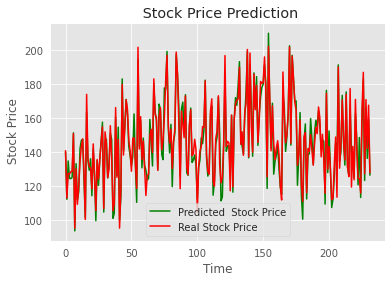

In [39]:
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [40]:
# Converting model from HDF5 format to TFJS format...
!pip install tensorflowjs[wizard]
# Need to be done on a CLI and not in notebook
!tensorflowjs_converter --input_format=keras /kaggle/working/model.h5 /kaggle/working/model-tjs

     |████████████████████████████████| 81 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 108 kB 6.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 180 kB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 40 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 127 kB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 701 kB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 145 kB 5.4 MB/s eta 0:00:01
     |████████████████████████████████| 217 kB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 322 kB 5.7 MB/s eta 0:00:01
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
     |████████████████████████████████| 462 kB 5.7 MB/s eta 0:00:01
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
     |████████████████████████████████| 3.8 MB 6.6 MB/s eta 0:00:01
Processing /home/micatske/.cache/pip/wheels/5f/fd/9e/b6cf5890494cb8ef